# Lab 06: Transforming and Comparing Data

This lab is presented with some revisions from [Dennis Sun at Cal Poly](https://web.calpoly.edu/~dsun09/index.html) and his [Data301 Course](http://users.csc.calpoly.edu/~dsun09/data301/lectures.html)

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)

In this section, we will transform and combine existing variables to obtain new variables. Our examples are drawn from a data set of house prices in Ames, Iowa.  This data set is stored in a tab-separated values file.  For more information about the variables in this data set, please refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [1]:
# clone the course repository, change to right directory, and import libraries.
%cd /content
!git clone https://github.com/nmattei/cmps3160.git
%cd /content/cmps3160/_labs/Lab06
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/content
Cloning into 'cmps3160'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (491/491), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 1601 (delta 299), reused 407 (delta 248), pack-reused 1110
Receiving objects: 100% (1601/1601), 40.48 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (900/900), done.
/content/cmps3160/_labs/Lab06


In [2]:
df = pd.read_csv('../data/ames.tsv', sep="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Applying Transformations

### Quantitative Variables

There are several reasons to transform quantitative variables, including:

1. to change the measurement units
2. to make the variable more amenable to analysis

As an example of the first reason, suppose we want the lot areas to be in acres instead of square feet. Since there are 43560 square feet in an acre, this requires dividing each lot area by 43560. We can **broadcast** the division over the entire `Series`.

In [3]:
df["Lot Area"] / 43560

0       0.729339
1       0.266804
2       0.327525
3       0.256198
4       0.317493
          ...   
2925    0.182208
2926    0.203972
2927    0.239692
2928    0.229798
2929    0.221006
Name: Lot Area, Length: 2930, dtype: float64

If we want to store the results as a new variable in the `DataFrame`, we simply assign the `Series` to a new column in the `DataFrame`. The command below does two things: creates a new column in the `DataFrame` called "Lot Area (acres)" _and_ populates it with the values from the `Series` above. (See? it's all the way on the right!)

In [4]:
df["Lot Area (acres)"] = df["Lot Area"] / 43560
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Lot Area (acres)
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,215000,0.729339
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000,0.266804
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000,0.327525
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,244000,0.256198
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900,0.317493


The second reason for transforming quantitative variables is to make them more amenable to analysis. To see why a variable might not be amenable to analysis, let's take a look at a histogram of lot areas.

<Axes: ylabel='Frequency'>

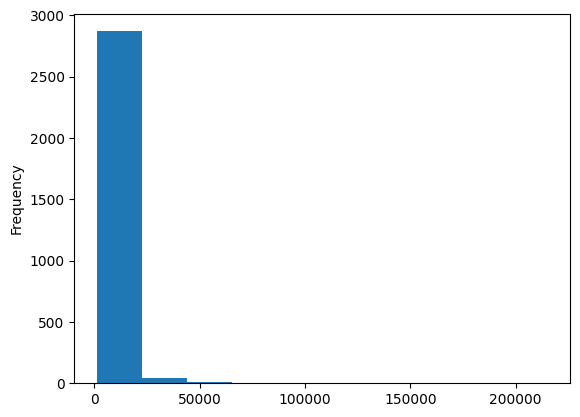

In [5]:
df["Lot Area"].plot.hist()

There are a few homes with such extreme lot areas that we get virtually no resolution at the lower end of the distribution. Over 95% of the observations are in a single bin of this histogram. In other words, this variable is extremely **skewed**.

One way to improve this histogram is to use more bins. But this does not solve the fundamental problem: we need more resolution at the lower end of the scale and less resolution at the higher end. One way to spread out the values at the lower end of a distribution and to compress the values at the higher end is to take the logarithm (provided that the values are all positive). Log transformations are particularly effective at dealing with right-skewed data.

The log function is not built into Python or `pandas`. We have to import the log function from a library called `numpy`, which contains many functions and data structures for numerical computations. In fact, `pandas` is built on top of `numpy`. When we apply `numpy`'s `log` function to a `pandas` `Series`, the function is automatically broadcast over the elements of the `Series`, returning another `Series`. Let's save the results to a variable called "log(Lot Area)".

In [6]:
import numpy as np
df["log(Lot Area)"] = np.log(df["Lot Area"])
df["log(Lot Area)"]

0       10.366278
1        9.360655
2        9.565704
3        9.320091
4        9.534595
          ...    
2925     8.979291
2926     9.092120
2927     9.253496
2928     9.211340
2929     9.172327
Name: log(Lot Area), Length: 2930, dtype: float64

These numbers are not very interpretable on their own, but if we make a histogram of these values, we see that the lower end of the distribution is now more spread out, and the extreme values are not so extreme anymore.

<Axes: ylabel='Frequency'>

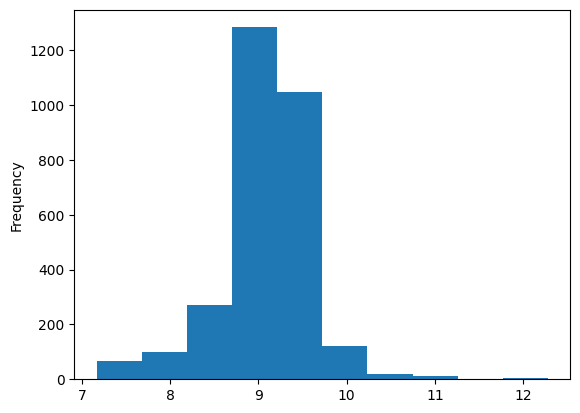

In [7]:
df["log(Lot Area)"].plot.hist()

It is possible for a log transformation to overcorrect for skew. For example, the "SalePrice" variable is also right-skewed.

<Axes: ylabel='Frequency'>

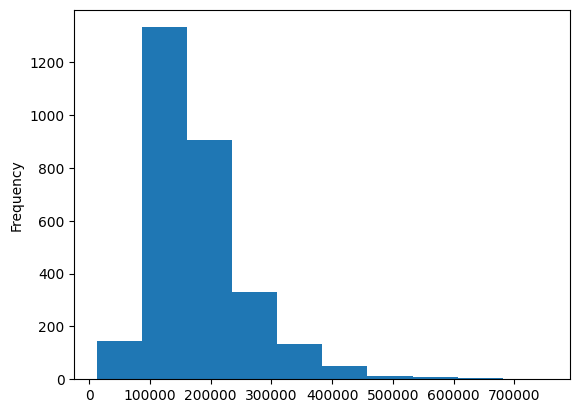

In [8]:
df["SalePrice"].plot.hist()

But if we take logs, the distribution becomes somewhat left-skewed.

<Axes: ylabel='Frequency'>

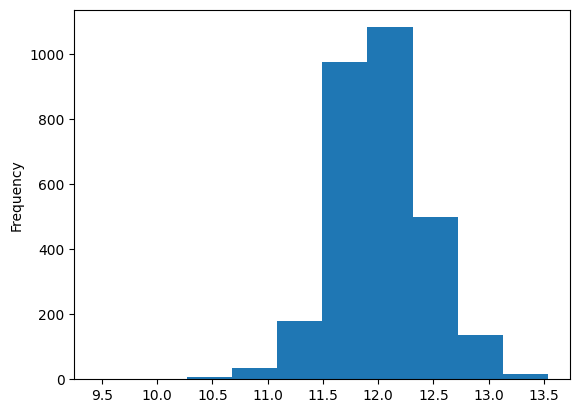

In [9]:
np.log(df["SalePrice"]).plot.hist()

Is there a transformation that makes the resulting distribution more symmetric?

In fact, log is just one transformation in a whole family of transformations. Because the transformations in this family involve raising the values to some power, the statistician John Tukey called this the **ladder of powers**:

$$ x(\lambda) = \begin{cases} x^\lambda & \lambda > 0 \\  \log(x) & \lambda = 0 \\ -x^\lambda & \lambda < 0 \end{cases} $$

$\lambda = 1$ corresponds to no transformation at all. As we decrease $\lambda$, the distribution becomes more left-skewed (which is useful if the original distribution was right-skewed). Since log ($\lambda = 0$) was an overcorrection, let's back off and increase $\lambda$:

<Axes: ylabel='Frequency'>

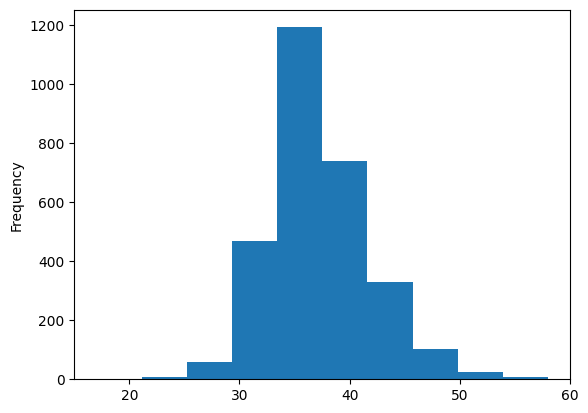

In [10]:
(df["SalePrice"] ** .3).plot.hist()

This seems to be better. We can move $\lambda$ up and down the ladder until the distribution is the shape we want.

### Why $\lambda = 0$ corresponds to $\log$

You might have noticed that it does not make sense to use the transformation $x^0$ for $\lambda = 0$, since anything raised to the zero power equals 1. But why is $\log(x)$ the right function to replace $x^0$?

The answer has to do with calculus. We want to understand the behavior of $x^\lambda$ as $\lambda$ approaches 0. To do this properly, we actually need to consider the function

$$\frac{x^\lambda - 1}{\lambda}.$$

Subtracting 1 and dividing by $\lambda$ are just constants that shift and scale the distribution; they do not affect the overall shape of the distribution. Therefore, the histogram of $x^\lambda$ will look the same as the histogram of $(x^\lambda - 1) / \lambda$; only the axes will be different.

Using calculus, you can show that the limit of the above function as $\lambda$ approaches 0 is:

$$\lim_{\lambda \to 0} \frac{x^\lambda - 1}{\lambda} = \log(x).$$

(Challenge: prove this!) This is why it makes sense to slot $\log(x)$ in for $x^0$.

### Other Mathematical Functions in Numpy

You might wonder what other mathematical functions are available in `numpy` besides `log`. For one, there is `log10`, which implements the base-10 logarithm. (By default, `np.log` is the natural logarithm, base-$e$.)

[Here is an exhaustive list of the mathematical functions](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.math.html). All of these functions are compatible with `pandas`.

### Categorical Variables

Categorical variables sometimes also require transformation, although for different reasons than quantitative variables. With categorical variables, the values are usually labels, so it does not make sense to take logarithms or to raise them to powers. However, we might want to change the labels of the categories.

For example, according to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt), the categorical variable "Heating QC" (heating quality and condition) in the Ames data set has five categories: excellent, good, average/typical, fair, and poor.

In [11]:
df["Heating QC"]

0       Fa
1       TA
2       TA
3       Ex
4       Gd
        ..
2925    TA
2926    TA
2927    TA
2928    Gd
2929    Ex
Name: Heating QC, Length: 2930, dtype: object

The categories are currently labeled as "Ex", "Gd", "TA", "Fa", and "Po", which might be cryptic to a reader. We might want to replace them with more descriptive labels. This requires a transformation.

To do this, we can use the `.map()` method of `Series`. This method takes as input a dictionary that specifies the mapping between the current labels and the desired labels. So, for example, if we want all instances of "Ex" to be replaced by "Excellent", we would add the key "Ex" to this dictionary, with a value of "Excellent".

In [12]:
df["Heating QC"].map({
    "Ex": "Excellent",
    "Gd": "Good",
    "TA": "Average",
    "Fa": "Fair",
    "Po": "Poor"
})

0            Fair
1         Average
2         Average
3       Excellent
4            Good
          ...    
2925      Average
2926      Average
2927      Average
2928         Good
2929    Excellent
Name: Heating QC, Length: 2930, dtype: object

Now when we make a bar chart, the labels will come out correctly. We just have to make sure they come out in the order we want.

<Axes: >

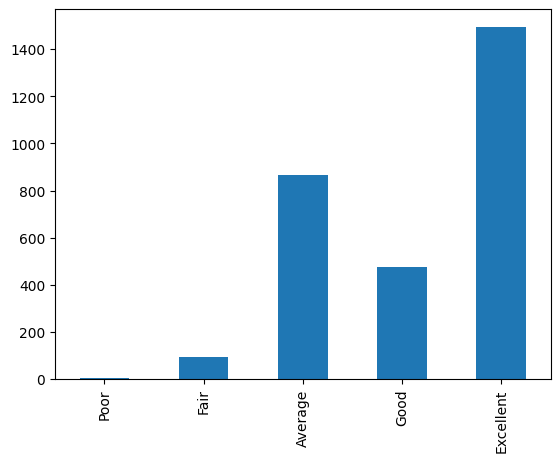

In [13]:
df["Heating QC"].map({
       "Ex": "Excellent",
       "Gd": "Good",
       "TA": "Average",
       "Fa": "Fair",
       "Po": "Poor"
}).value_counts()[["Poor", "Fair", "Average", "Good", "Excellent"]].plot.bar()

Transformations of categorical variables are not always merely cosmetic. For example, we may want to combine several categories into one. The code below turns heating quality into a binary categorical variable (acceptable / unacceptable), according to whether the heating quality is at least average:

In [14]:
df["Heating QC Binary"] = df["Heating QC"].map({
       "Ex": "Acceptable",
       "Gd": "Acceptable",
       "TA": "Acceptable",
       "Fa": "Unacceptable",
       "Po": "Unacceptable"
})

df["Heating QC Binary"]

0       Unacceptable
1         Acceptable
2         Acceptable
3         Acceptable
4         Acceptable
            ...     
2925      Acceptable
2926      Acceptable
2927      Acceptable
2928      Acceptable
2929      Acceptable
Name: Heating QC Binary, Length: 2930, dtype: object

The binary variable contains less information than the original variable, but we may not need the finer-grained detail about the heating, if all we want to know is whether it is acceptable or not.

In [15]:
df["Heating QC Binary"].value_counts()

Acceptable      2835
Unacceptable      95
Name: Heating QC Binary, dtype: int64

## Combining Variables

We can also create new variables out of multiple existing variables. For example, in the current data set, the information about when a house was sold is spread across two variables, "Yr Sold" and "Mo Sold" (1-12 indicating the month). We can combine these two variables into one, by dividing the month the house was sold by 12 and then adding that to the year. So for example, this new variable would equal 2010.5 if the house was sold in June 2010 and 2006.75 if it was sold in September 2006.

In [16]:
df["Date Sold"] = df["Yr Sold"] + df["Mo Sold"] / 12
df["Date Sold"]

0       2010.416667
1       2010.500000
2       2010.500000
3       2010.333333
4       2010.250000
           ...     
2925    2006.250000
2926    2006.500000
2927    2006.583333
2928    2006.333333
2929    2006.916667
Name: Date Sold, Length: 2930, dtype: float64

Notice how the division by 12 is _broadcast_ over the elements of the `Series`, and the addition of the two `Series` is elementwise.

Another example of a variable that can be derived from two existing variables is the _cost per square foot_, which is a common way to compare prices of different-sized homes. To calculate the cost per square foot of a home, we can simply divide the two `Series`, and the division will be elementwise.

In [17]:
df["Cost per Sq Ft"] = df["SalePrice"] / df["Gr Liv Area"]
df["Cost per Sq Ft"]

0       129.830918
1       117.187500
2       129.420617
3       115.639810
4       116.574586
           ...    
2925    142.073779
2926    145.232816
2927    136.082474
2928    122.390209
2929     94.000000
Name: Cost per Sq Ft, Length: 2930, dtype: float64

# Relationships Between Variables

## Visualization

Let's start by visualizing the relationship between the square footage (of the dwelling) and the sale price, both of which are quantitative variables. To do this, we can make a **scatterplot**. In a scatterplot, each observation is represented by a point. The $(x, y)$ coordinates of each point represent the values of two variables for that observation.

To make a scatterplot in `pandas`, we use the `.plot.scatter()` method of `DataFrame`. Since there are multiple columns in the `DataFrame`, we have to specify which variable is $x$ and which variable is $y$.

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

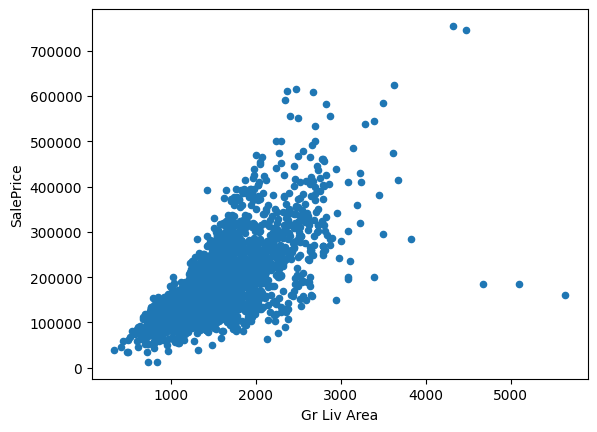

In [18]:
df.plot.scatter(x="Gr Liv Area", y="SalePrice")

We see that square footage (of the dwelling) and the sale price have a positive relationship. That is, the greater the living area, the higher the sale price.

## Summary Statistics

To summarize the relationship between two quantitative variables $X$ and $Y$, we can report the _covariance_ between them, defined as

$$ \text{Cov}[X, Y] = \frac{1}{n - 1} \sum_{(x,y)}(x - \text{mean}[X]) (y - \text{mean}[Y])$$

The sign of the covariance will match the direction of the relationship between the two variables. The figures below illustrate why. If two variables are positively related, then the scatterplot might look as follows, with most points in the upper-right and lower-left quadrants (when you divide up the plane into four quadrants based on the means of $X$ and $Y$).

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/positive_cov.png?raw=1)

Each point on this scatterplot contributes to the sum that makes up the covariance. Any point in the upper-right quadrant (where $x$ and $y$ are both greater than their respective means) has a positive contribution, since the product of two positive numbers is positive. A point in the lower-left quadrant (where $x$ and $y$ are both less than their respective means) also has a positive contribution, since the product of two negative numbers is also positive. Therefore, on the whole, the covariance will be positive for two variables with a positive relationship.

We can also consider two variables with a negative relationship. A scatterplot of two negatively-related variables might look as follows, with most points in the upper-left and lower-right quadrants. Points in both of these quadrants will have a negative contribution towards the covariance, since the product of a positive and a negative number is negative.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/negative_cov.png?raw=1)

What does it mean for the covariance to be _zero_? It does not necessarily mean that there is _no_ relationship at all between the two variables; it just means that the two variables do not move in a consistent direction. For example, the two variables below have _zero_ covariance because the negative contributions from the upper-left and lower-right quadrants perfectly cancel out the positive contributions from the upper-right and lower-left quadrants. However, it would be inaccurate to say that $X$ and $Y$ have _no_ relationship; they have a strong relationship, but it just is not consistently in one direction.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/zero_cov.png?raw=1)

To calculate the covariance between two quantitative variables, we use the `.cov()` method in `pandas`. This method is attached to one `Series` and takes another `Series` of the same length as input. It returns the covariance between the two `Series`.

In [19]:
df["Gr Liv Area"].cov(df["SalePrice"])

28542199.568276513

The covariance between the two variables is positive, as should be apparent from the scatterplot above. Larger houses sell for higher prices.

One criticism of the covariance is that the value itself is difficult to interpret, and covariances are not comparable across different variables.  As we did with the $\chi^2$ distance in the previous section, we can normalize the covariance. This _normalized covariance_ is called the **correlation** and is symbolized $r$:

$$ r = \frac{\text{Cov}[X, Y]}{\text{SD}[X] \text{SD}[Y]} $$

Note that formally this is the [Pearson Correlation Coefficient for a population](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), but we can just call it the correlation coefficient for now.

The correlation has all of the important properties of covariance:

- A positive correlation indicates a positive relationship between the variables. As one increases, so does the other.
- A negative correlation indicates a negative relationship between the variables. As one increases, the other tends to decrease.
- A zero correlation means that the two variables do not move in a consistent direction, but does not necessarily mean that they have _no_ relationship.

But the correlation is also guaranteed to be between $-1$ and $1$, so it can be compared across data sets.

What does a maximal correlation of $\pm 1$ mean? It means that the data fall perfectly along a line.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/corr_1.png?raw=1)

Correlation is calculated in `pandas` in much the same way that covariance is, using the `.corr()` method:

In [20]:
df["Gr Liv Area"].corr(df["SalePrice"])

0.7067799209766279

Like the covariance, the correlation $r$ is positive, but it is a number between $-1$ and $+1$. $r=+1$ would mean that all of the points on the scatterplot fell perfectly along a line (with positive slope). Although the points in the scatterplot do not all fall perfectly on a line, they do seem to hover around an underlying line. This explains why the covariance is close to, but not equal to, $1$.

# Three Variables and Beyond
So far in this chapter, we have seen a few ways to summarize and visualize the relationship between two variables. But what if we are working with three or more variables? This section discusses some strategies for dealing with multivariate data.

## Mapping Aesthetics to Variables

In Section 3.3, we made a scatterplot showing the relationship between living area and sale price. What if we also want to understand how number of bedrooms enters into the equation?

One possibility is to make a three-dimensional scatterplot. However, 3D plots are often misleading when represented in two dimensions, and they don't generalize well to even higher dimensions. A better approach is to use other _aesthetics_ of the plot, such as the color or size of the points, to represent additional variables.

The `.plot.scatter()` function in `pandas` allows us to control four aesthetics of a scatterplot. We've seen two already:

- `x=`: the variable on the $x$-axis
- `y=`: the variable on the $y$-axis

but there are two more:

- `c=`: the colors of the points (either the name of a variable in the `DataFrame` or an array specifying the color of each point)
- `s=`: the sizes of the points (must be an array specifying the size of each point)

For example, to use color to represent the number of bedrooms, we could do the following:

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

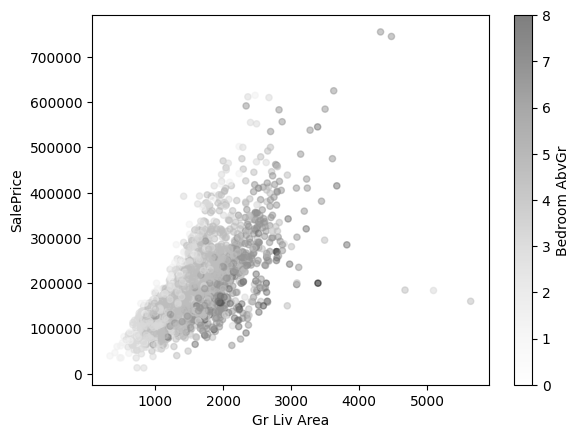

In [21]:
df.plot.scatter(x="Gr Liv Area", y="SalePrice",
                c="Bedroom AbvGr", alpha=.5)

Notice how the colors become darker as you move down the plot. This means that, holding living area constant, a house is less expensive the _more_ bedrooms it has. (Why do you think this is?)

Now, number of bedrooms is a quantitative variable. What if we wanted to visualize how a categorical variable, such as building type, interacts with these two quantitative variables (living area and sale price)? We have to manually construct the array of colors using the `.map()` function we learned in Lab 1.

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

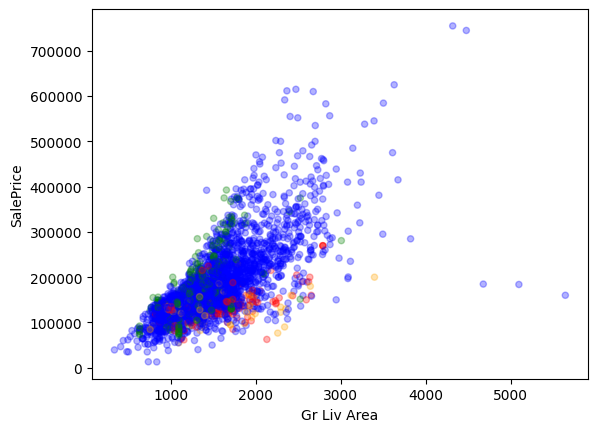

In [22]:
cols = df["Bldg Type"].map({
    "1Fam": "blue",
    "TwnhsE": "green",
    "Twnhs": "green",
    "Duplex": "red",
    "2fmCon": "orange"
})

df.plot.scatter(x="Gr Liv Area", y="SalePrice",
                c=cols, alpha=.3)

## Small Multiples

Rather than try to pack all of the variables into a single plot, we can juxtapose several plots or "facets", each showing the data from a slightly different angle. Edward Tufte coined the term "small multiples" for this type of graphic.

For example, rather than use color to represent building type, we could have made 5 separate scatterplots, one for each building type, and arranged them in a row for easy comparison.

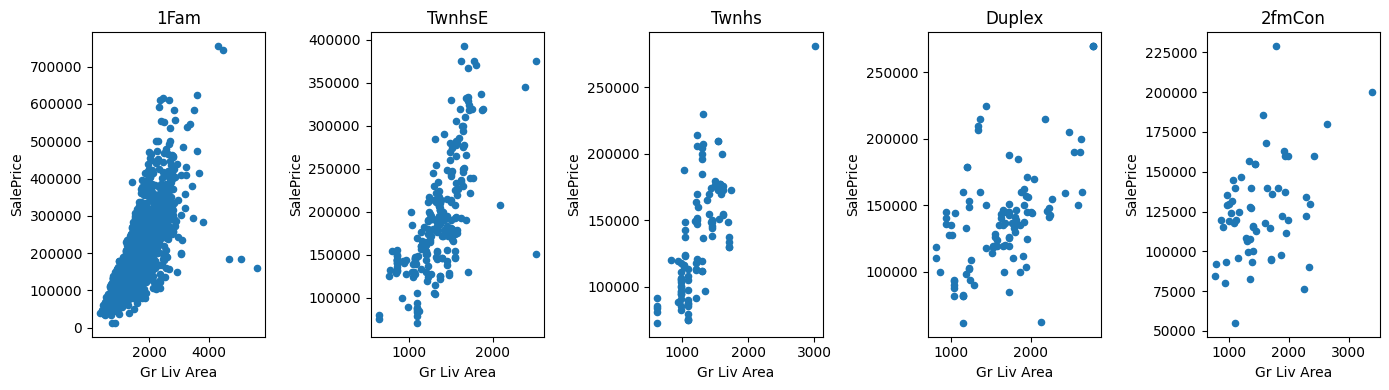

In [23]:
# Specifies a 1 x 5 grid of plots, figsize in inches
fig, axes = plt.subplots(1, 5, figsize=(14, 4))

bldg_types = df["Bldg Type"].unique()
for ax, bldg_type in zip(axes, bldg_types):
    housing_type = df[df["Bldg Type"] == bldg_type]
    housing_type.plot.scatter(x="Gr Liv Area", y="SalePrice", ax=ax)
    ax.set_title(bldg_type)
plt.tight_layout()

Of course, the goal of such a graphic is to facilitate comparison, which is difficult when the $x$- and $y$-axes of the facets are so different. Since the facets are aligned horizontally, it makes sense to use a common $y$-axis for all of them. We can do this by specifying `sharey=True` in `plt.subplots()`. (There is also a corresponding `sharex=` argument.)

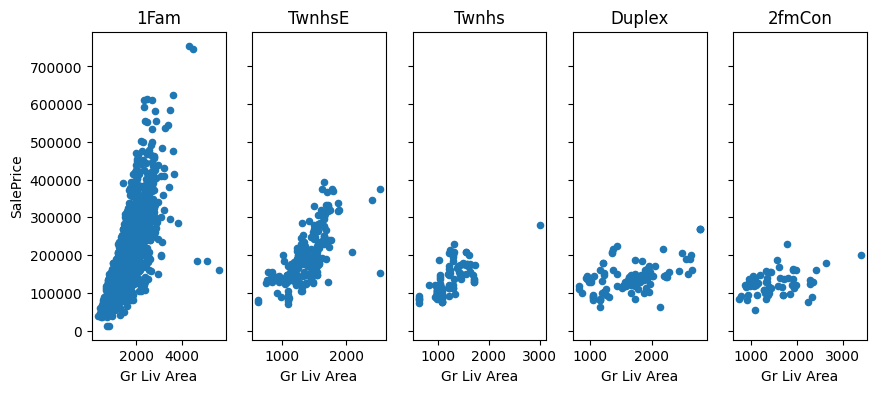

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4), sharey=True)

bldg_types = df["Bldg Type"].unique()
for ax, bldg_type in zip(axes, bldg_types):
    housing_type = df[df["Bldg Type"] == bldg_type]
    housing_type.plot.scatter(x="Gr Liv Area", y="SalePrice", ax=ax)
    ax.set_title(bldg_type)

Sharing the $y$-axes between the facets also resolved another issue---the colliding $y$-axis labels---since now only the first plot in the figure has an $y$-axis label.

## Grammar of Graphics

The **grammar of graphics** organizes the ideas above into a coherent philosophy. The key insight is that a graphic can be specified by mapping its "aesthetics" (e.g., color, size, $x$-axis, column facet) to variables in a data set. Although `pandas` provides some support for this philosophy (as we have seen above), the process is tedious and often requires writing boilerplate code. For example, in order to use color to represent building type, we had to manually map each building type to a color. Libraries based on the grammar of graphics provide a more friendly interface and hide this complexity from the user.

Software packages that implement the grammar of graphics include `ggplot2` in R and [Altair](https://altair-viz.github.io/) in Python. Since we are working in Python, we will use Altair. The first step is to import the package.  You will need to install this package on the data science docker image.  If you want go check them out for your final project.  [Seaborn](https://seaborn.pydata.org/) is another package we have discussed which allows for this.

## Summary Statistics

When there are three or more variables, summarizing the relationships can be difficult, so it is usually more fruitful to produce a visualization. That said, there are a few commonly used summary statistics for multivariate data.

The **covariance matrix** is exactly what its name implies; it is a matrix whose $(i, j)$th entry is the covariance between variable $i$ and variable $j$. It is obtained by calling `.cov()` on a `DataFrame`.

In [25]:
variables = ["Gr Liv Area",
             "Bedroom AbvGr",
             "Full Bath",
             "SalePrice"]

df[variables].cov()

,Gr Liv Area,Bedroom AbvGr,Full Bath,SalePrice
Gr Liv Area,2.555392e+05,216.245415,176.184999,2.854220e+07
Bedroom AbvGr,2.162454e+02,0.685139,0.164533,9.516233e+03
Full Bath,1.761850e+02,0.164533,0.305743,2.410074e+04
SalePrice,2.854220e+07,9516.232724,24100.740965,6.381884e+09


Likewise, the **correlation matrix** is just the corresponding matrix of correlations. All of its entries are between $-1$ and $+1$. It is obtained by calling `.corr()` on a `DataFrame`.

In [26]:
df[variables].corr()

,Gr Liv Area,Bedroom AbvGr,Full Bath,SalePrice
Gr Liv Area,1.000000,0.516808,0.630321,0.706780
Bedroom AbvGr,0.516808,1.000000,0.359489,0.143913
Full Bath,0.630321,0.359489,1.000000,0.545604
SalePrice,0.706780,0.143913,0.545604,1.000000


# Exercises 
 The following questions continue using the `ames` data. Refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) if you have any trouble finding or understanding a variable in this data set.

#### Exercise 1 
What happens if you leave out a category in the dictionary that you pass to `.map()`?

In [ ]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

**Text Answer Here**.

#### Exercise 2
The number of bathrooms is typically reported as a decimal to allow for half bathrooms (i.e., bathrooms without a shower). In this data set, the number of full bathrooms and the number of half bathrooms are separate variables. Create a new variable with the number of bathrooms in each home. 

*Hint: look carefully at the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) to find everywhere that it reports bathrooms.*

In [28]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 3 
Create a categorical variable that indicates whether or not a home has a pool.  

*Hint: we can use the [map function...](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) because it can take a function.. or you can use the filtering learned in the last lab...*

In [29]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 4
 
 There are four types of utilities: electricity, gas, water, and sewage. Right now, the combination of utilities in a home is encoded in a single variable called "Utilities". Convert this variable into four boolean variables, each one indicating whether or not a home has a particular utility.

*Hint: Check the values before you start coding...*

In [30]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 5 
**The remaining questions deal with the Tips data set (`./data/tips.csv`).**

Make a visualization that shows the distribution of the total bills. Transform the variable first so that it is approximately symmetric.

In [31]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 6 

Suppose the total bill + tip are divided evenly among the people in each party. Which table paid the most _per person_?

In [32]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 7
 
 Make a visualization that shows how busy the restaurant is by day. Your visualization should display the full name of each day, i.e., "Thursday" instead of "Thur".

In [33]:
# ENTER YOUR CODE HERE and EXPLAIN AS COMMENTS

#### Exercise 8
 Make a scatterplot showing the relationship between the tip and the total bill. Use color to indicate whether the tipper was male or female and the size of each point to represent the party size. Be sure to include axis labels.

In [34]:
# ENTER YOUR CODE HERE

#### Exercise 9
 
 Calculate the correlation matrix summarizing the pairwise relationships between the quantitative variables in this data set. Interpret what you see. Which pair of variables in this data set have the highest correlation with each other? A question to answer is: **Why does it make sense that all of the diagonal entries of this matrix are equal to $1.0$?**

In [35]:
# ENTER YOUR CODE HERE

**Text Answer Here**.

#### Exercise 10
To build your intuition about correlation, play this [correlation guessing game](http://guessthecorrelation.com/). There is even a two-player mode that allows you to play against a friend in the class.  How long did you last?

**Text Answer Here**

### When you have filled out all the questions, submit via [Tulane Canvas](https://tulane.instructure.com/)